In [1]:
import numpy as np
import pandas as pd
from PyAstronomy import pyasl
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

# plt.style.use('seaborn')
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = '262629'
plt.rcParams['figure.facecolor'] = '262629'


In [2]:
dataset = pd.read_csv('../data/ExoTrain.csv')

In [3]:
def plot(series, title ,mode='o'):
    plt.figure(figsize=(15,5))
    plt.plot(series, mode, markersize=3)
    plt.title(title)
    plt.show()

In [4]:
dataset = dataset.values
labels = dataset[:,0]
dataset = dataset[:, 1:]


In [20]:
dataset_diff1 = dataset[:, 1:]-dataset[:, :-1]

Mean:  0.00744958883505


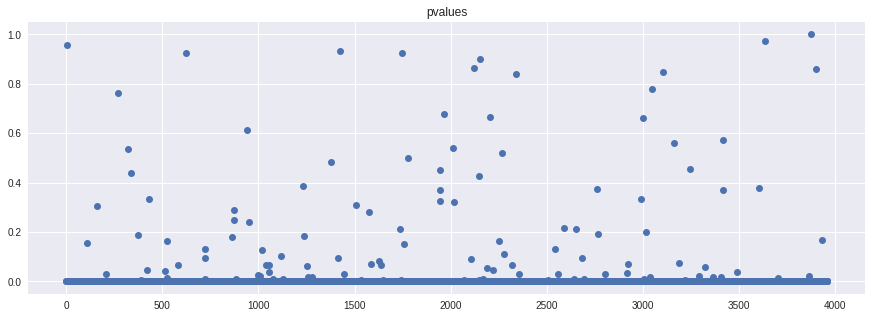

Outside Points 0.01: 103
Mean:  0.000549472124777


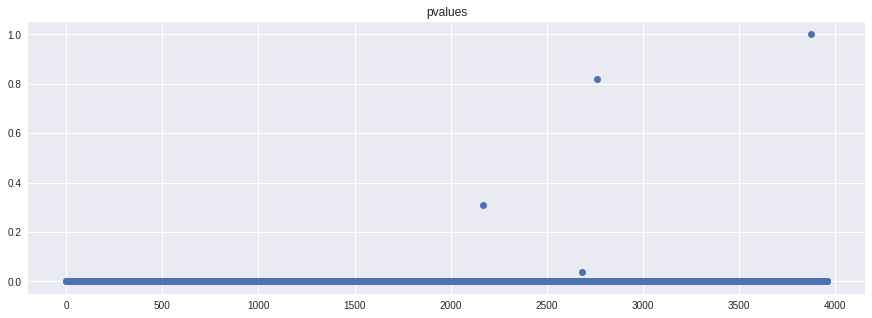

Outside Points 0.01: 4


In [216]:
# Normality Test
from scipy.stats.mstats import normaltest
from scipy.stats import describe

def normality_test(dataset):
    ret_val = normaltest(dataset, axis=1)
    print 'Mean: ',ret_val.pvalue.mean()

    plot(ret_val.pvalue, 'pvalues')
    print 'Outside Points 0.01:', np.sum(ret_val.pvalue>0.01)
    
normality_test(dataset)
normality_test(dataset_diff1)

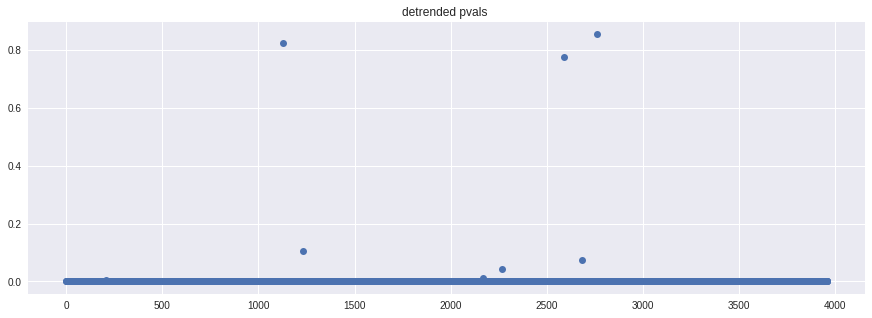

More than 0.01: 7


In [217]:
detrended = np.load('../features/detrend_median21.npy')
_, detrend_pvals = normaltest(detrended, axis=1)
plot(detrend_pvals, 'detrended pvals ')
print 'More than 0.01:', np.sum(detrend_pvals>0.01)

In [31]:
def plot_outliers(index, plot=True):
    k = dataset[index]
    g = gaussian_filter1d(k, sigma=100)
    mean = k.mean()
    std = k.std()
    
#     outliers = pyasl.generalizedESD(k, 100, 2)[1]
#     outliers = generalizedESD(k, 20, 0.5)[1]
#     outliers = pyasl.pointDistGESD(k, 20, alpha=2)[1]
    outliers = pyasl.slidingPolyResOutlier(np.arange(len(k)), k, points=80, count=70, deg=3, stdlim=3)[1]
#     def if_greater_than_mean_std(index):
#         if k[index]>mean+5*std: return True
#         return False
#     outliers = filter(if_greater_than_mean_std, outliers)
#   TODO Vectorize
#     def greater_than_gaussian(index):
#         return k[index]>g[index]+4*std
#     outliers = filter(greater_than_gaussian, outliers)
    outliers_filtered = np.where(k[outliers]>g[outliers]+4*std)[0]
    outliers = outliers[outliers_filtered]
    
    if plot:
        plt.figure(figsize=(15,4))
        plt.plot(k, 'o', markersize=3)
        plt.plot(g+4*std)
        plt.plot(outliers, k[outliers], 'ro', markersize=5)
        plt.title('Star %d'%i)
        plt.show()

In [32]:
ids = np.arange(3960)
np.random.shuffle(ids)

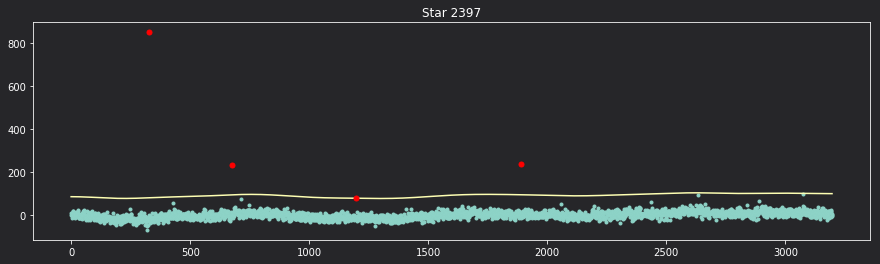

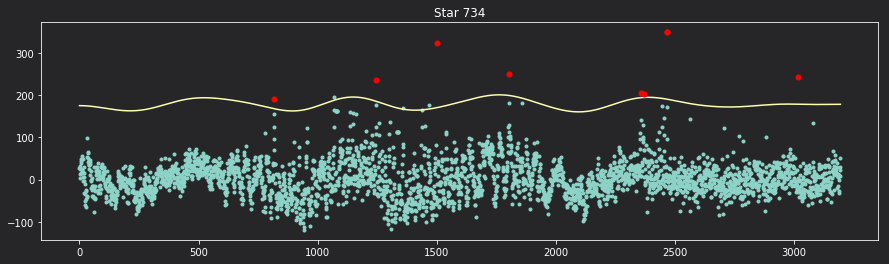

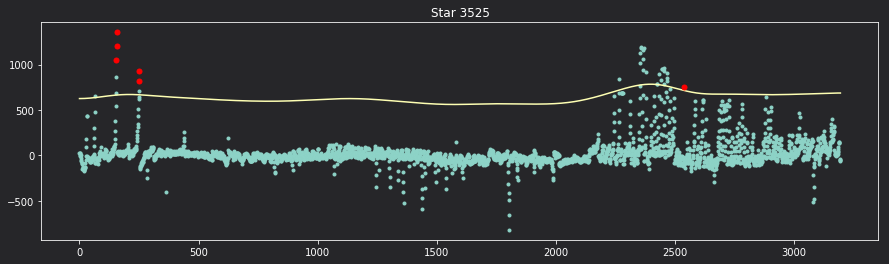

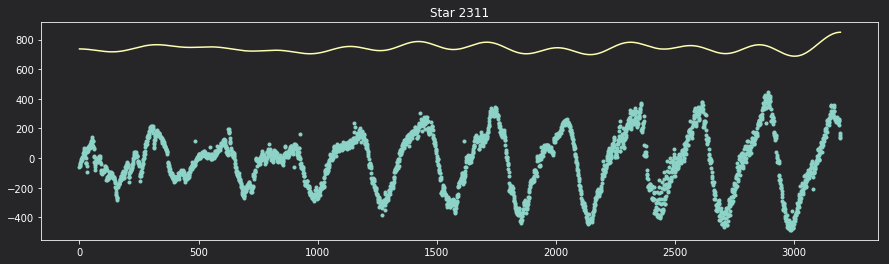

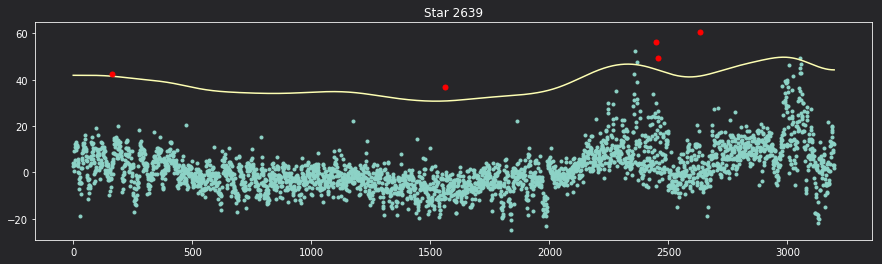

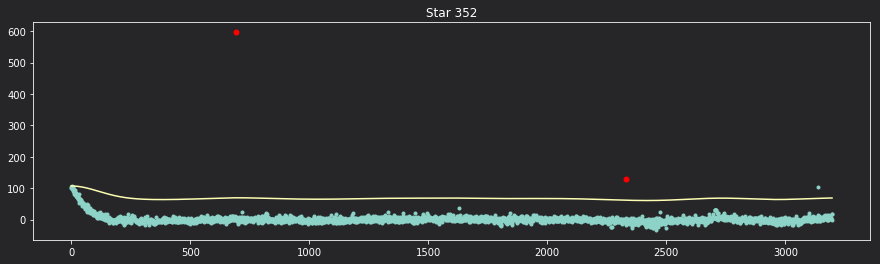

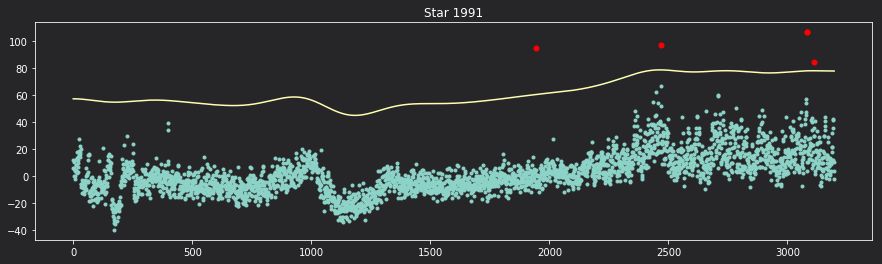

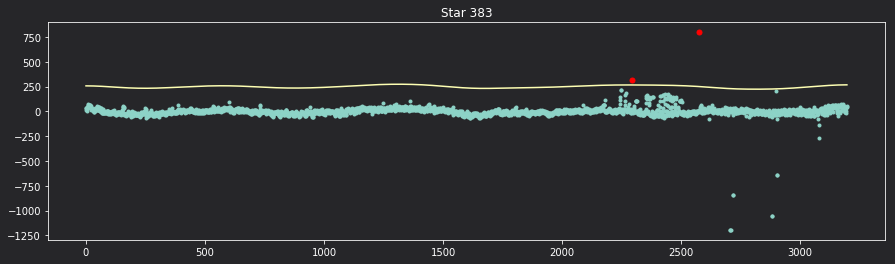

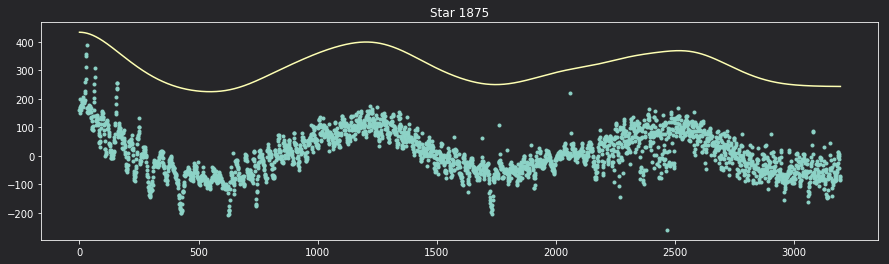

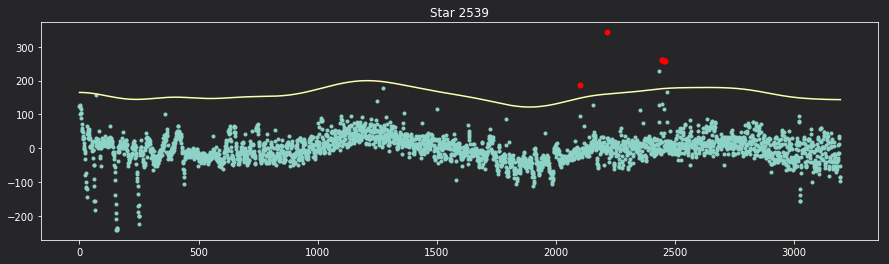

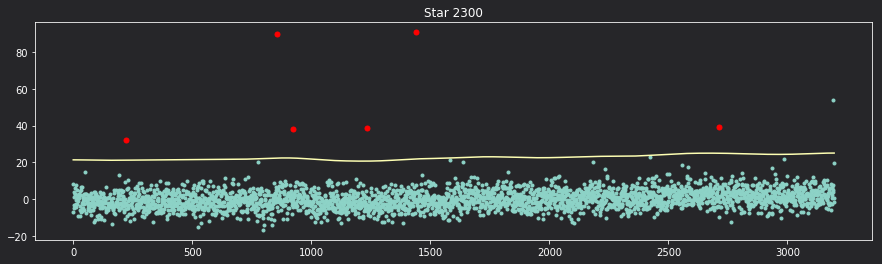

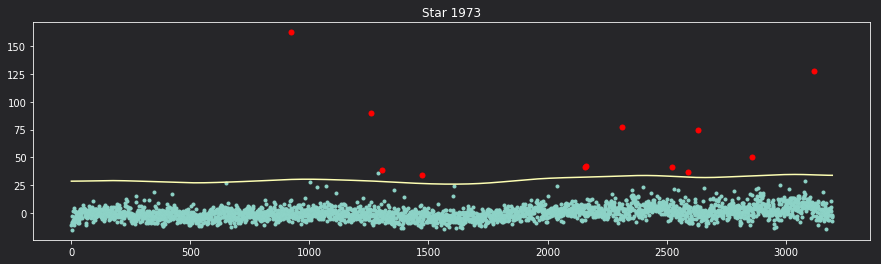

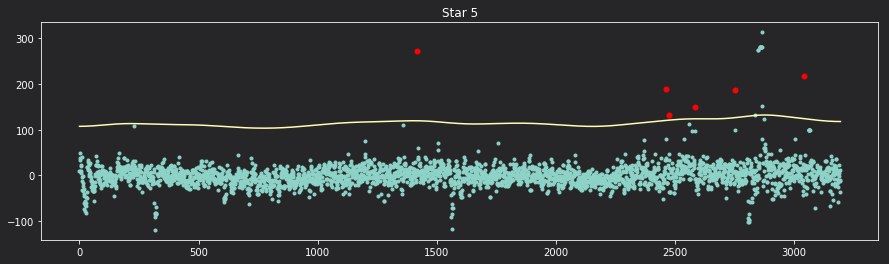

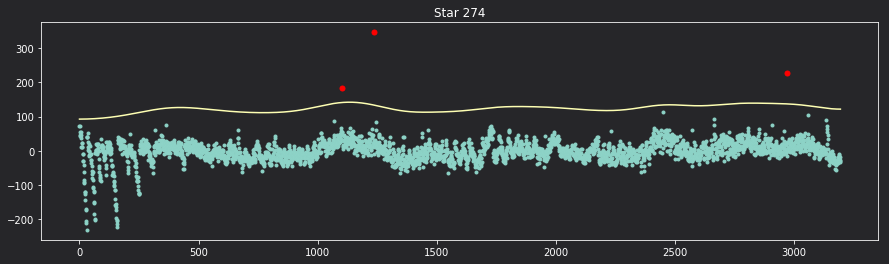

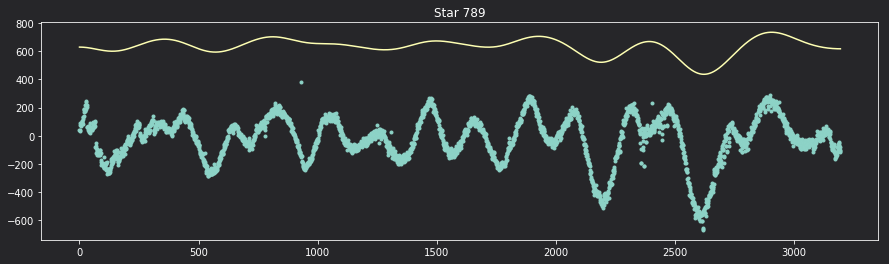

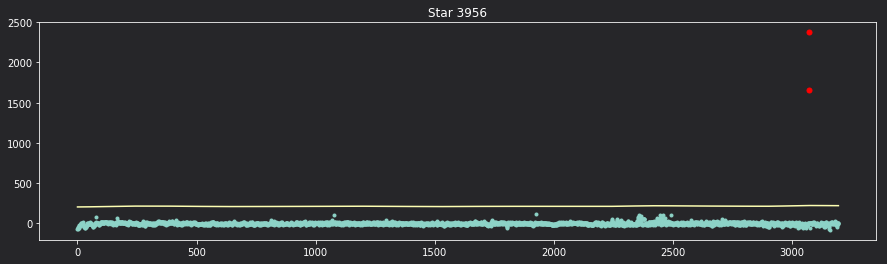

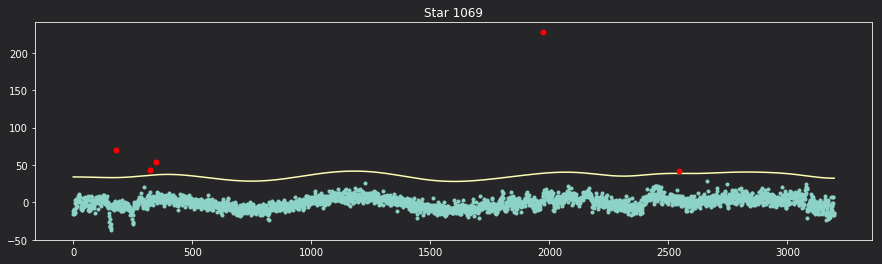

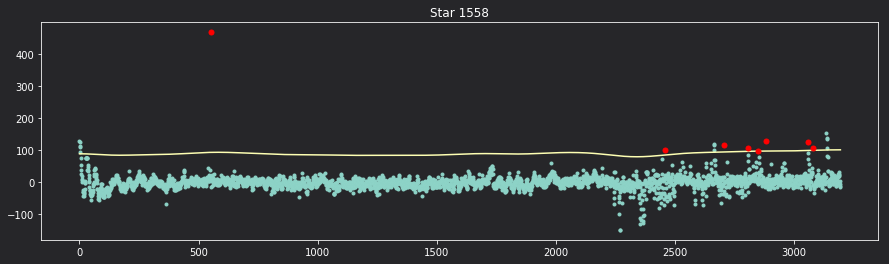

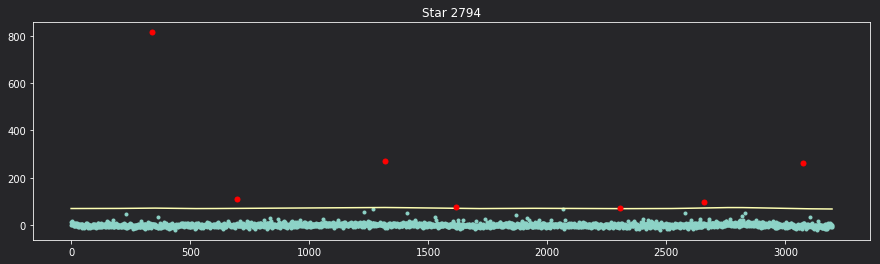

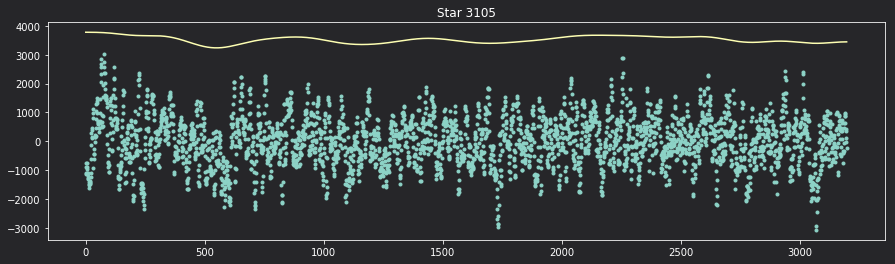

In [35]:

# for i in ids[:20]:
for i in ids[:20]:
# for i in range(30):
# # for i in np.where(labels==2)[0]:
    plot_outliers(i)

# plot_outliers(200)
# plot_outliers(609)
# plot_outliers(1220)
# plot_outliers(25)
# plot_outliers(3048)

In [7]:
def remove_outlier(series, points=80, count=70, deg=3, stdlim=3, trend_stdlim=4):
    series = np.copy(series)
    n = series.shape[0]
    trend = gaussian_filter1d(series, sigma=100)
    std = series.std()

    outliers = pyasl.slidingPolyResOutlier(np.arange(n), series, points=points, count=count, deg=deg, stdlim=stdlim)[1]
    outliers_filtered = np.where(series[outliers] > trend[outliers] + trend_stdlim * std)[0]
    outliers = outliers[outliers_filtered]

    for outlier in outliers:
        series[outlier] = np.median(series[outlier-20:outlier+20])

    return series

# %timeit -n 10 remove_outlier(dataset[0])

10 loops, best of 3: 967 ms per loop


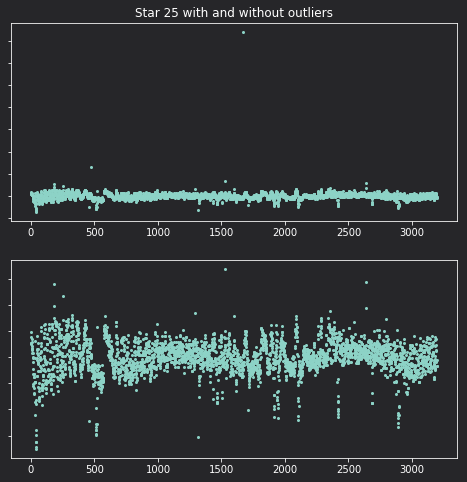

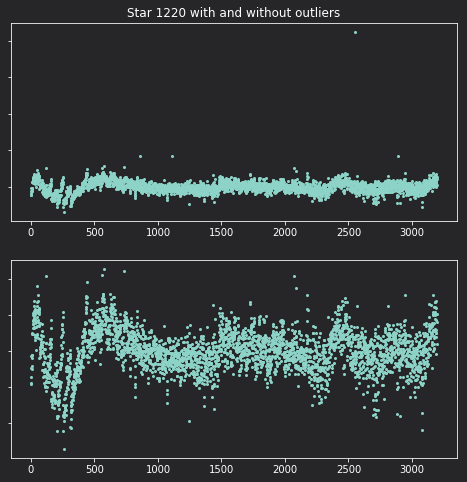

In [39]:
def plot_2(i, title):
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(2, 1, 1)
    plt.plot(dataset[i], 'o', markersize=2)
    plt.title(title)
    ax.set_yticklabels([])
    ax = plt.subplot(2, 1, 2)
    plt.plot(remove_outlier(dataset[i]), 'o', markersize=2)
    ax.set_yticklabels([])
    
    plt.show()

plot_2(25, 'Star 25 with and without outliers')
plot_2(1220, 'Star 1220 with and without outliers')
# plot_2(513, 503, 'Starts without Exoplanets')

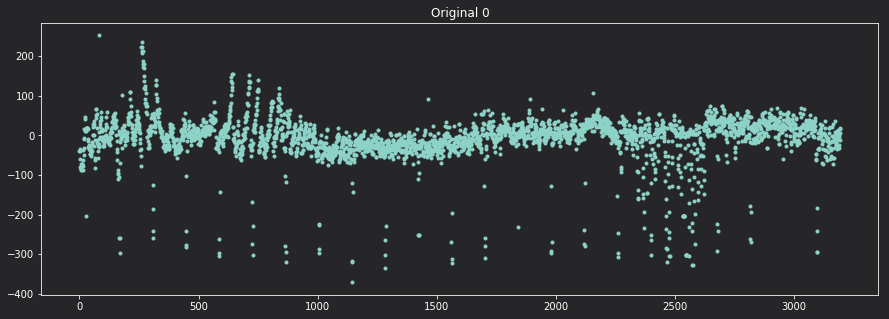

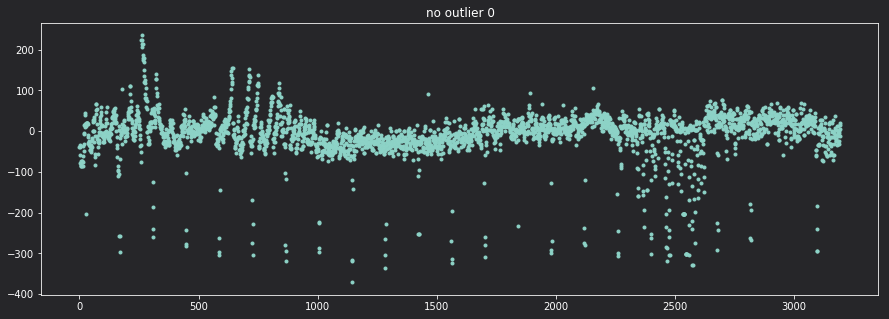

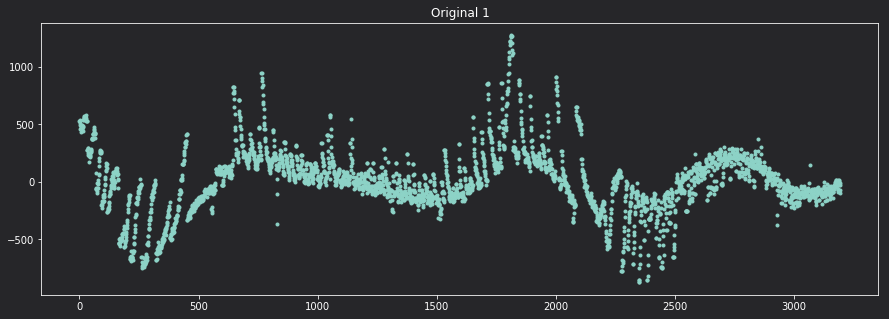

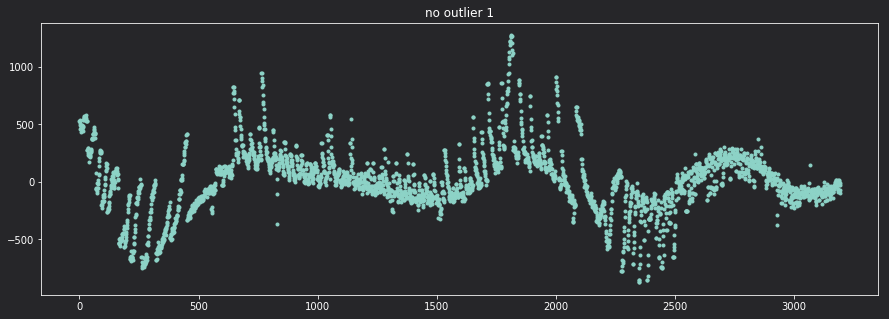

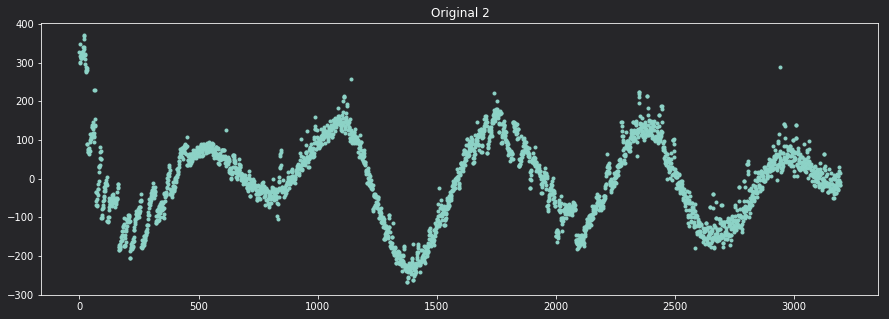

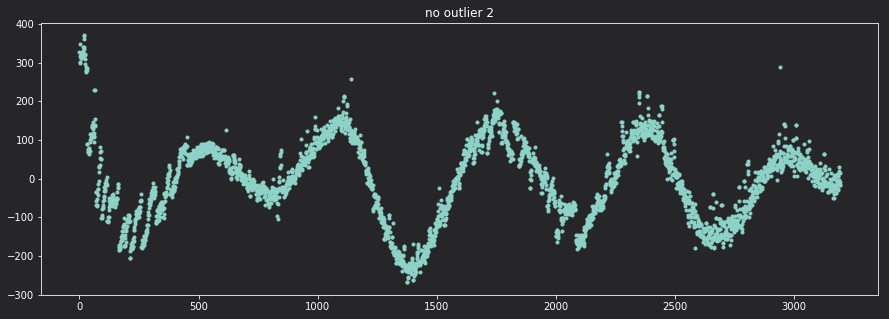

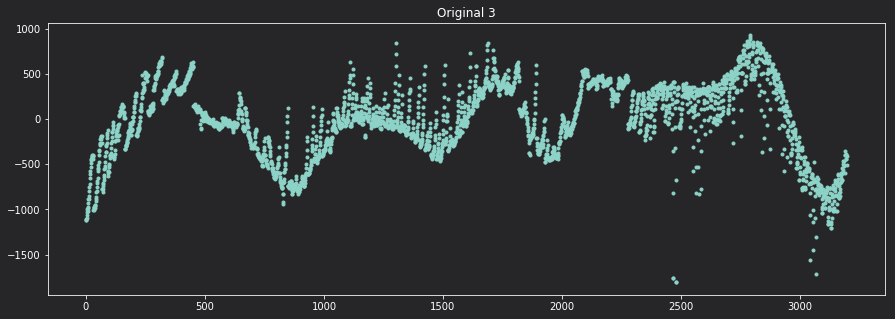

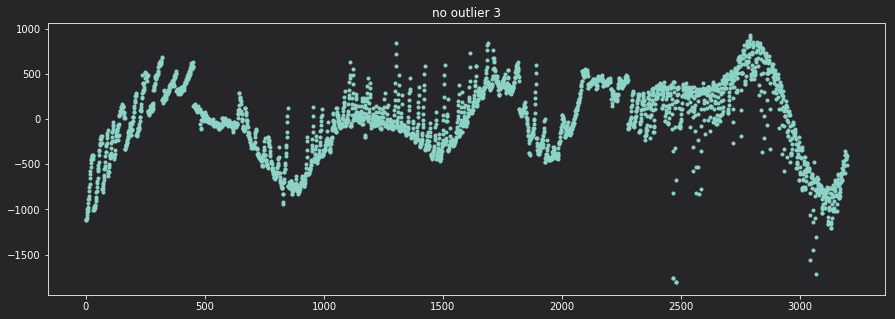

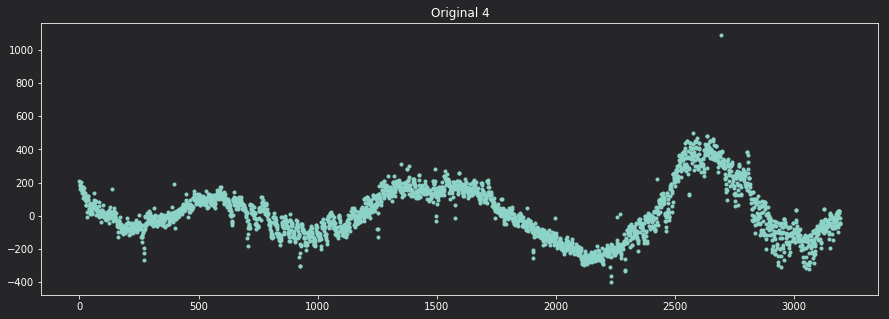

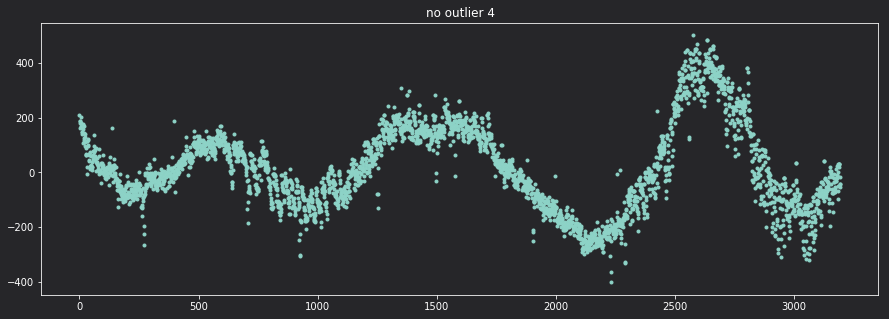

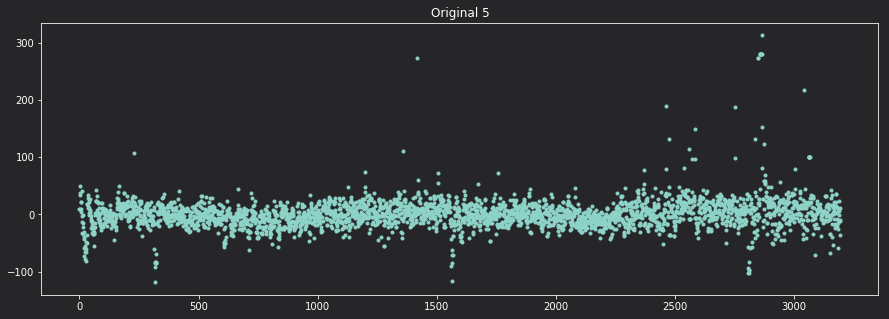

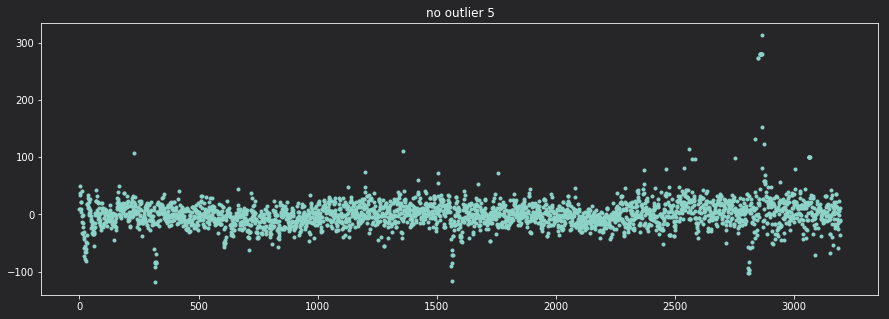

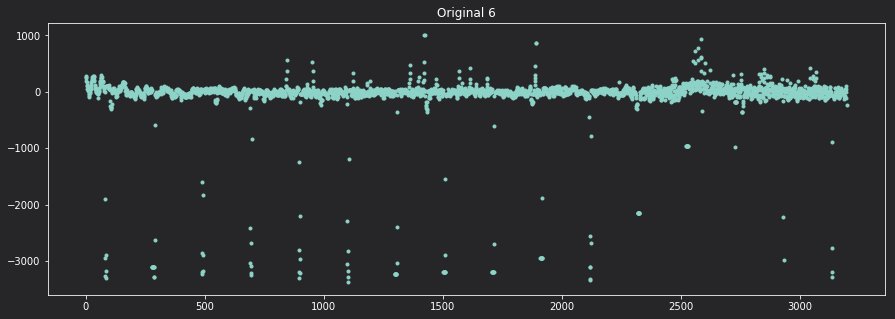

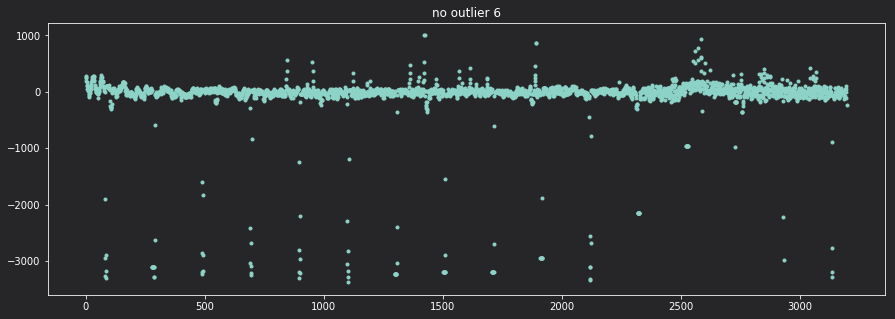

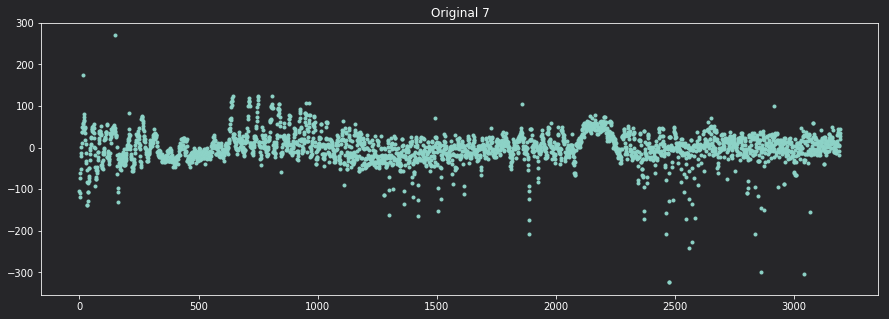

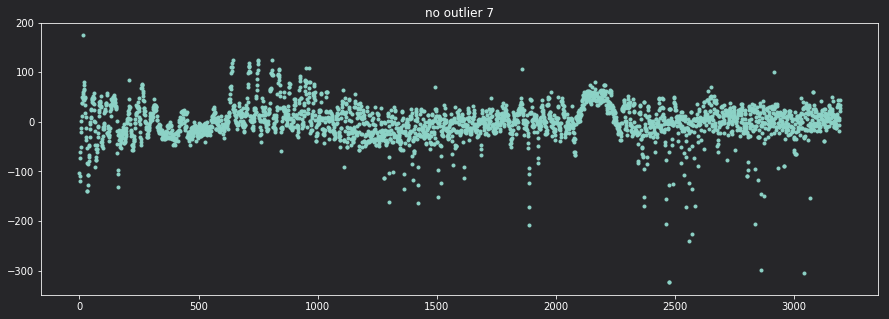

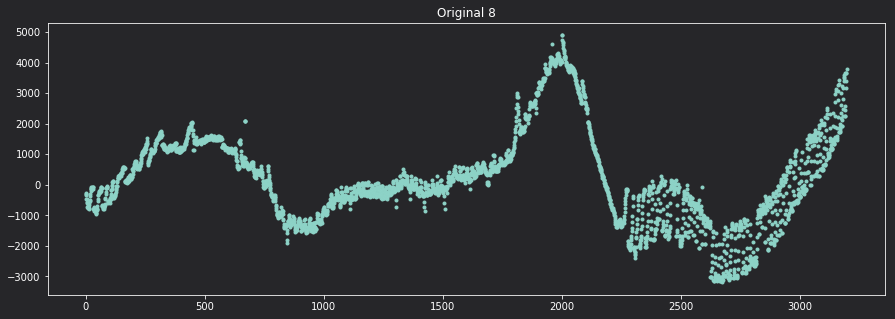

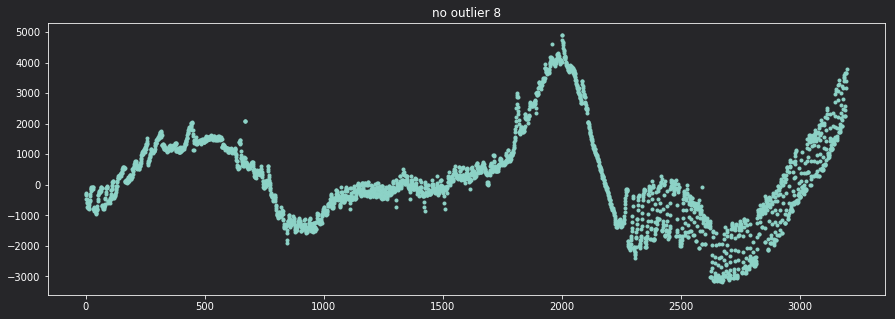

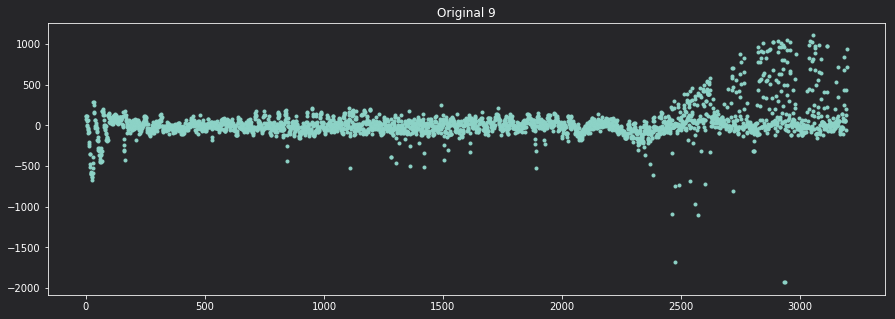

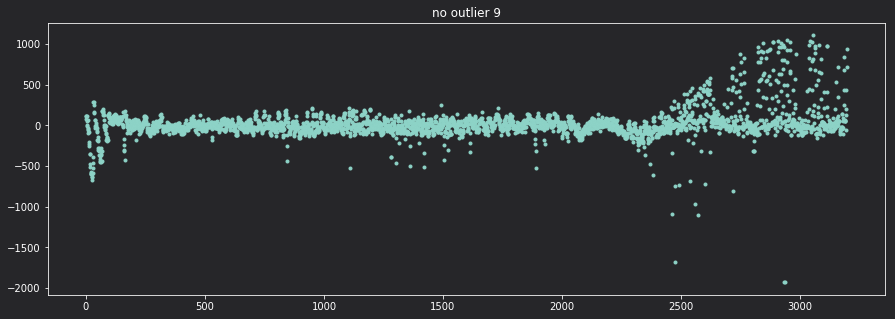

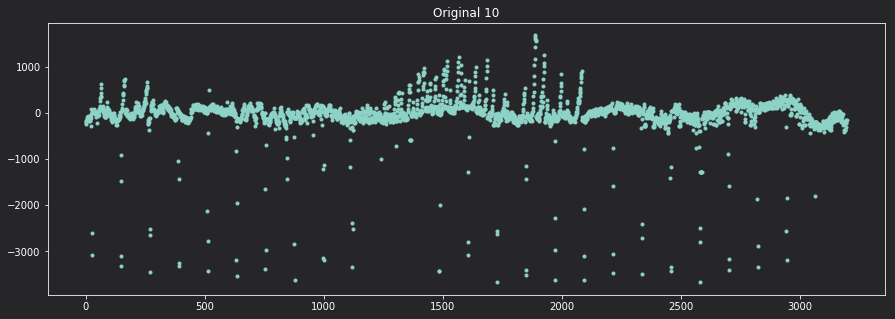

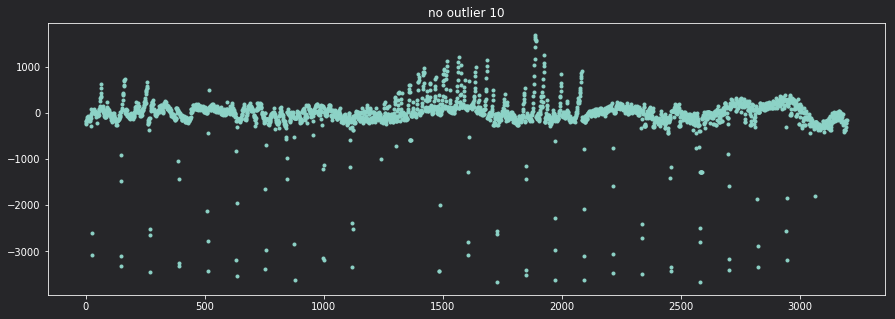

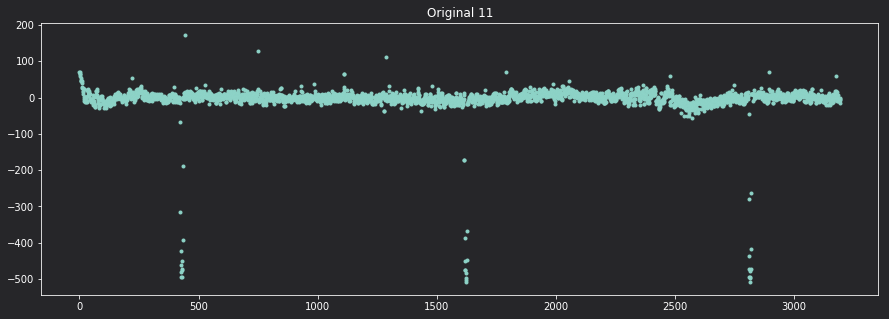

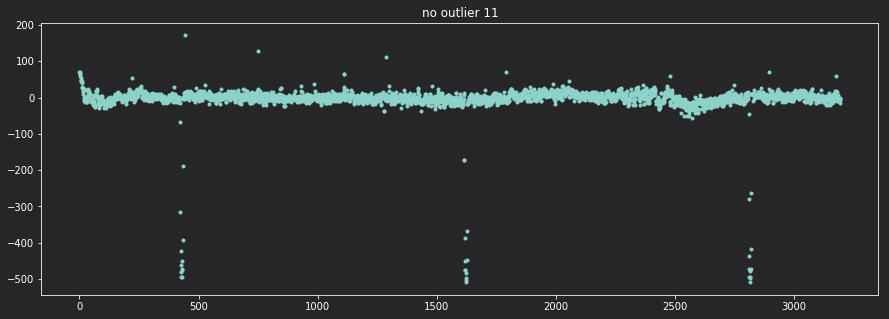

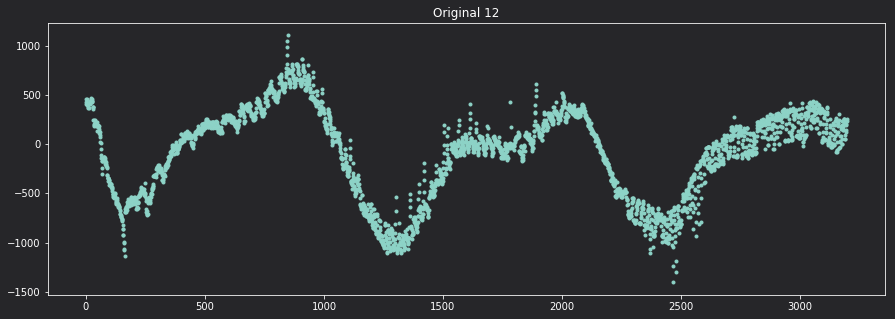

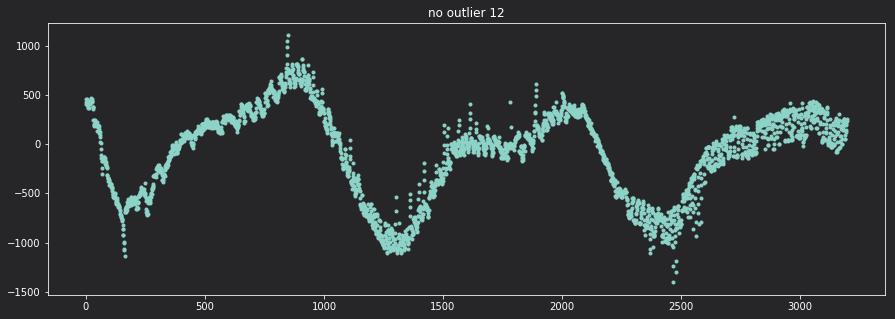

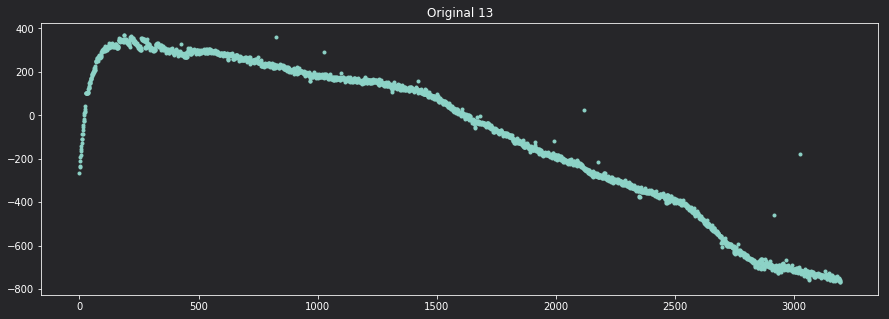

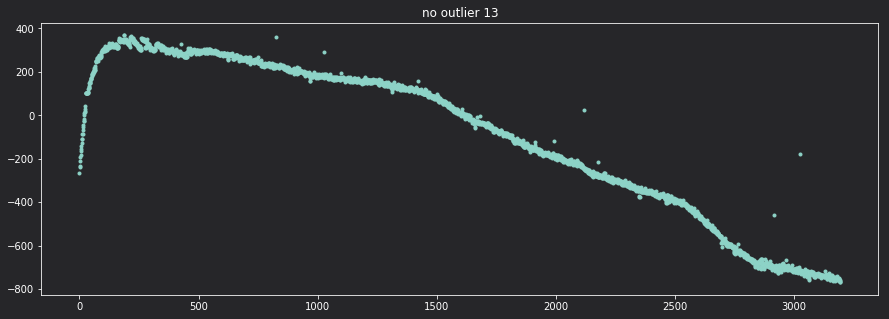

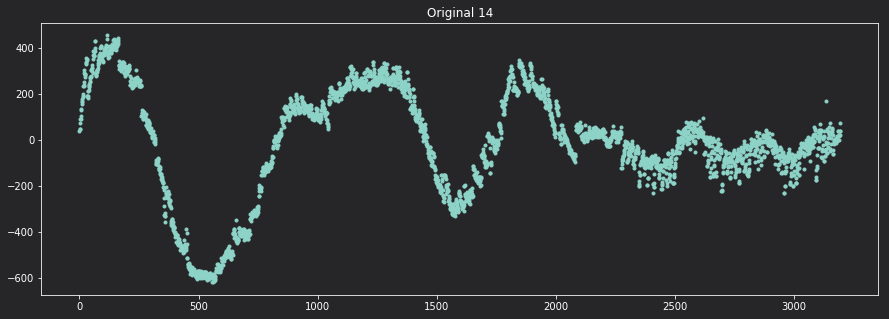

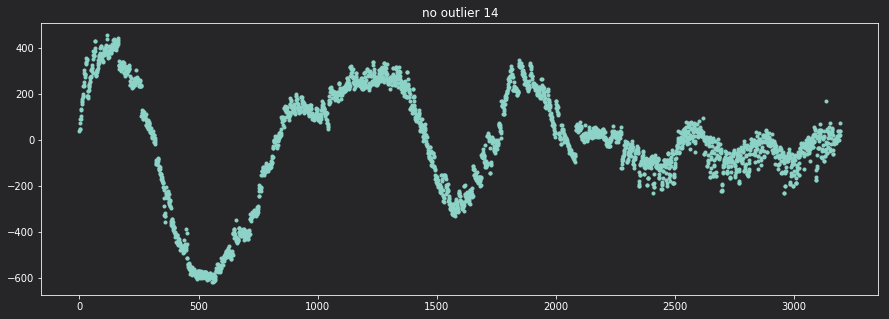

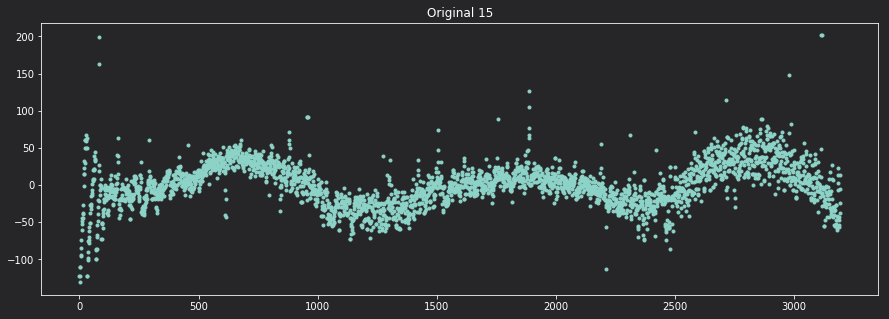

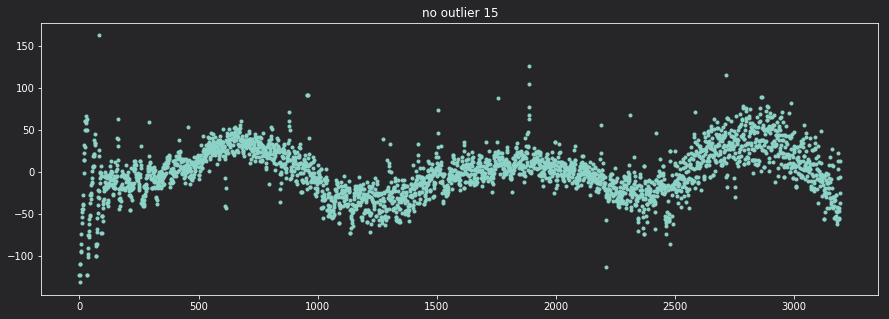

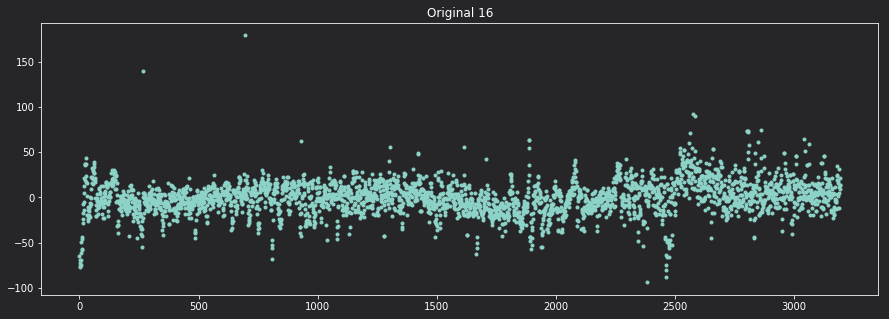

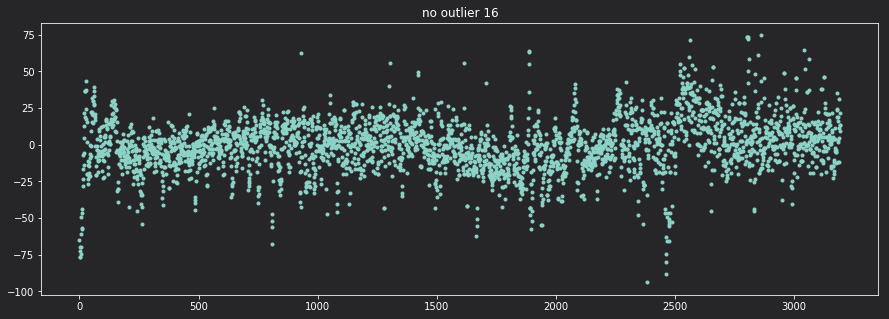

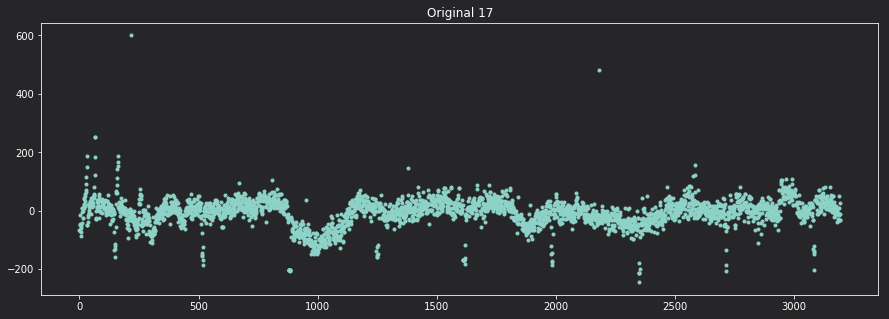

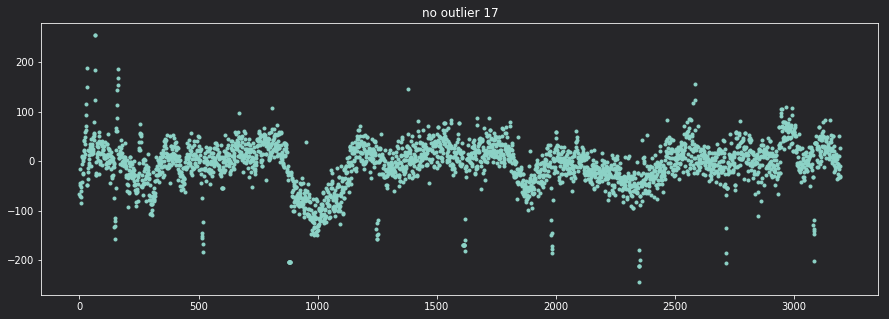

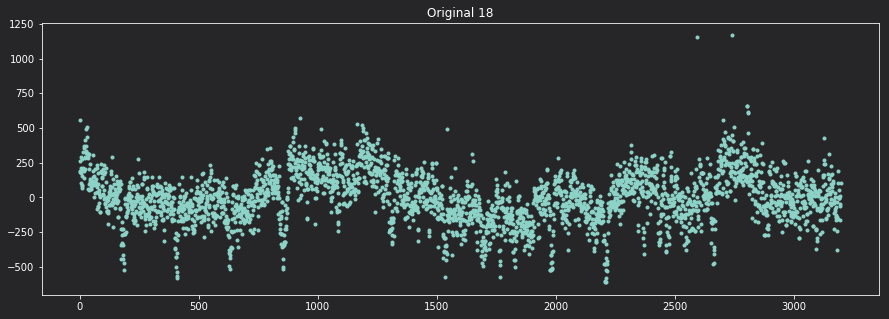

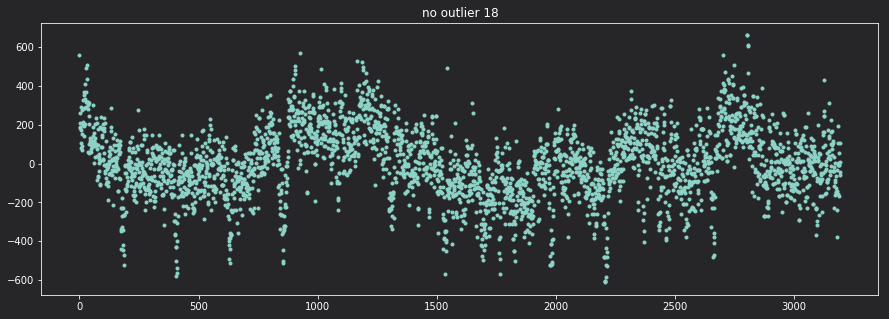

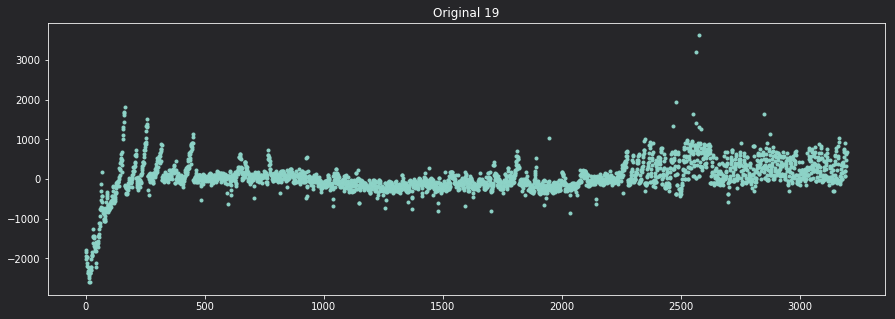

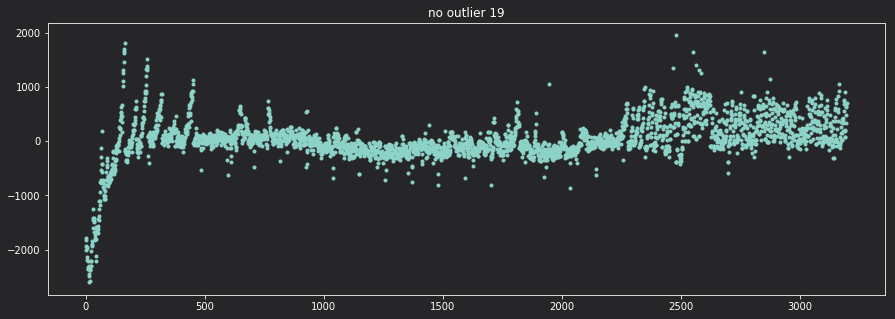

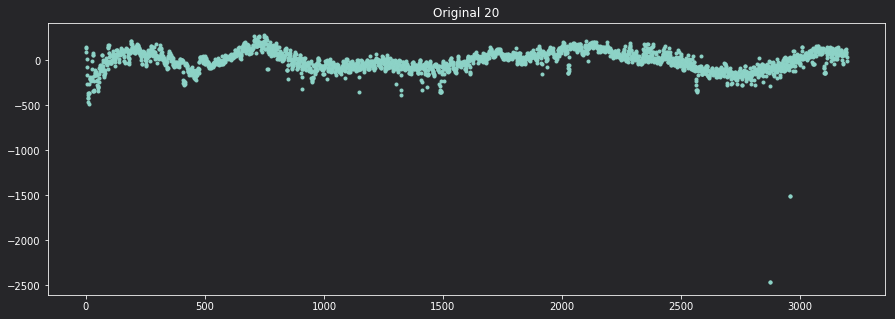

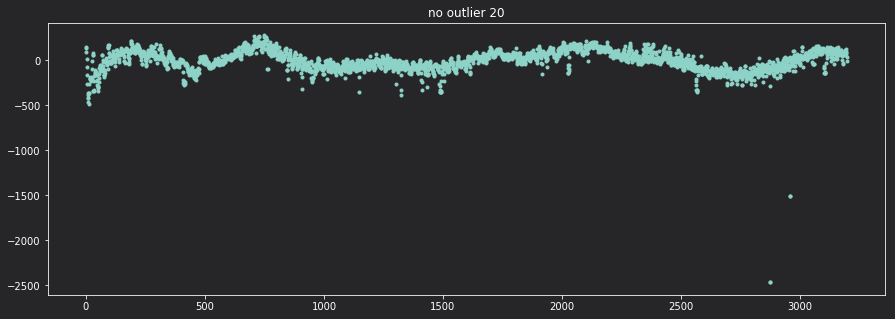

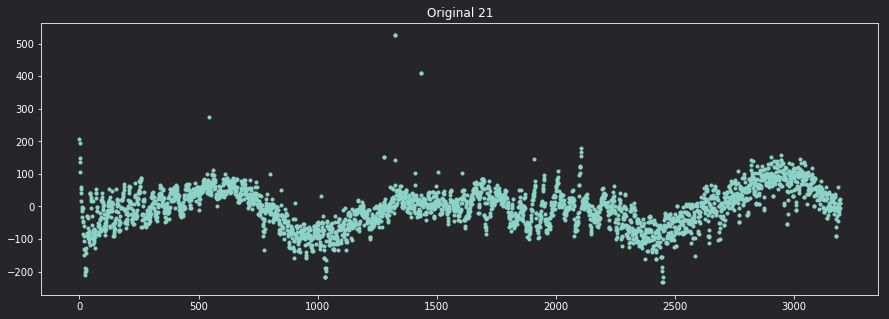

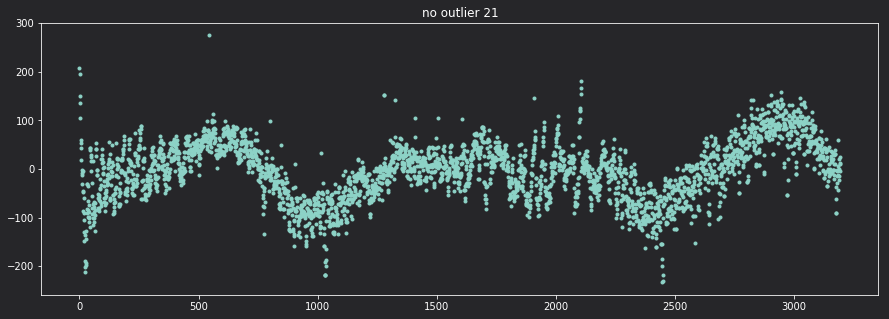

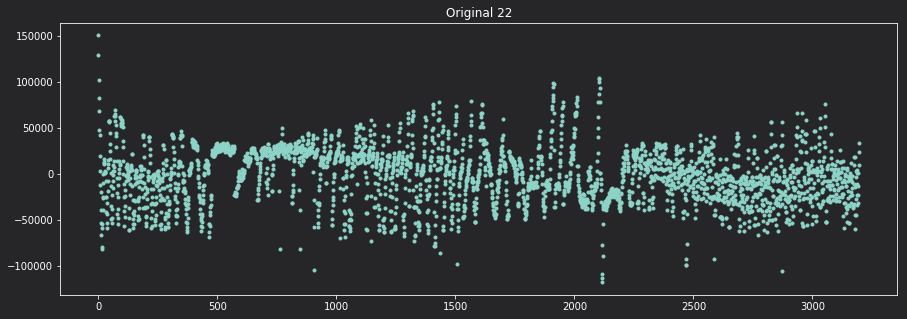

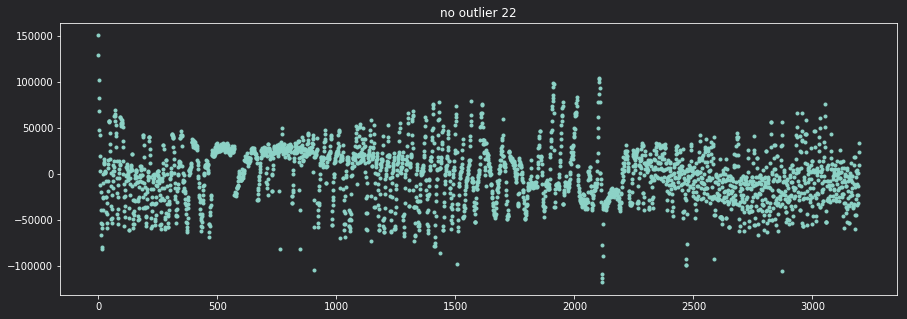

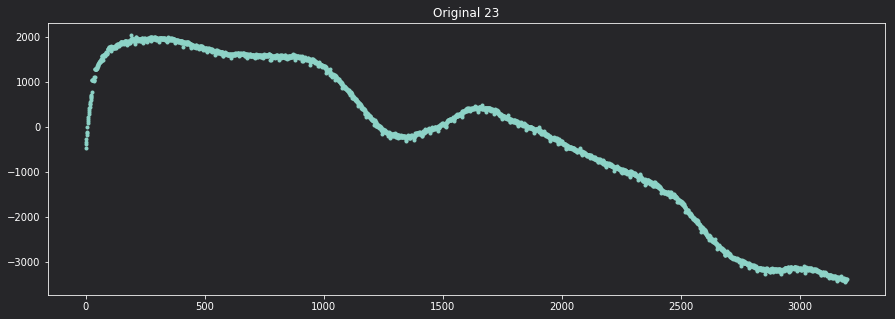

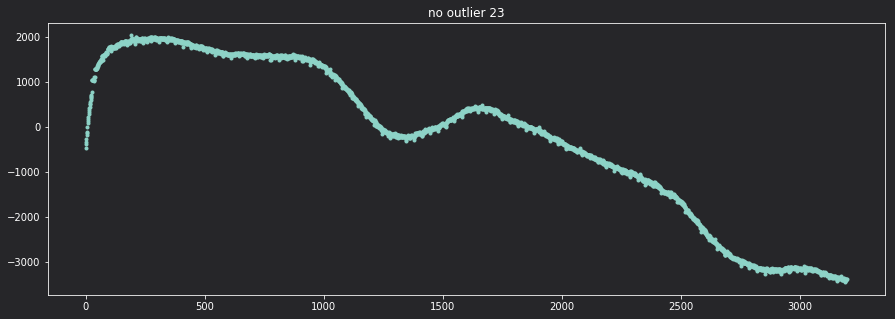

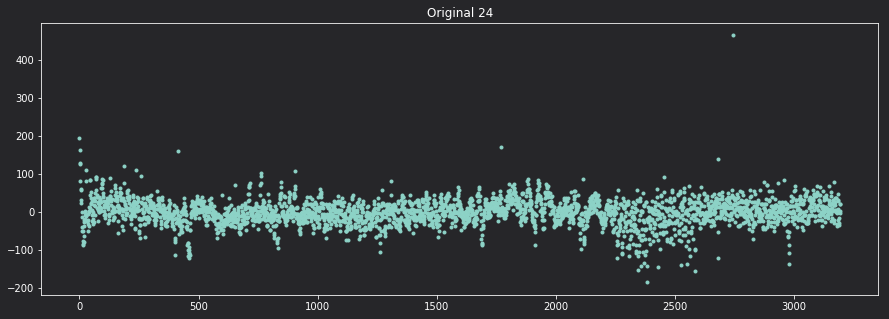

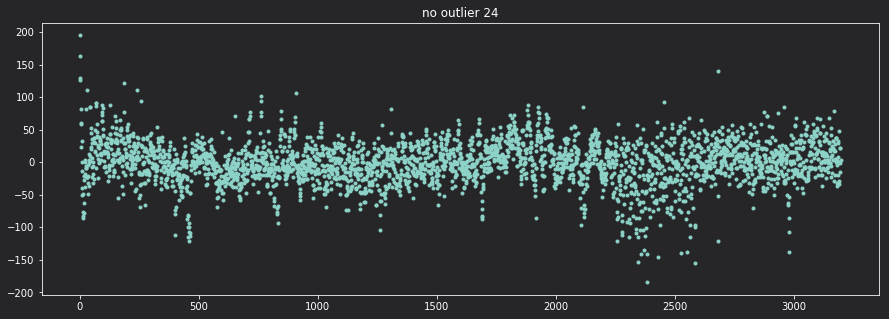

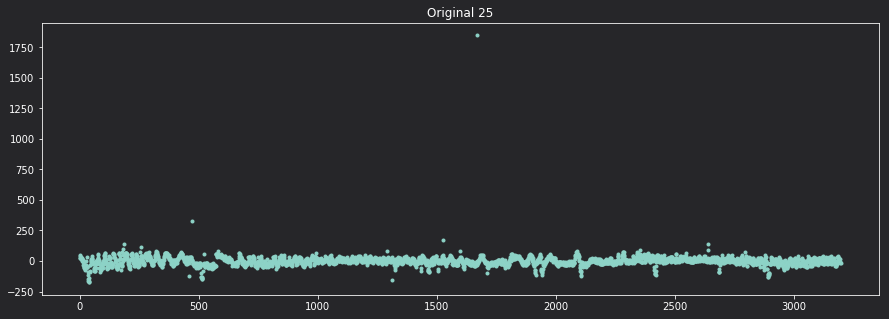

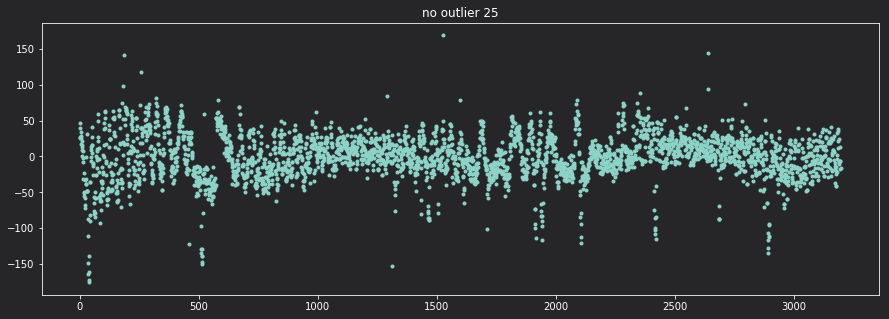

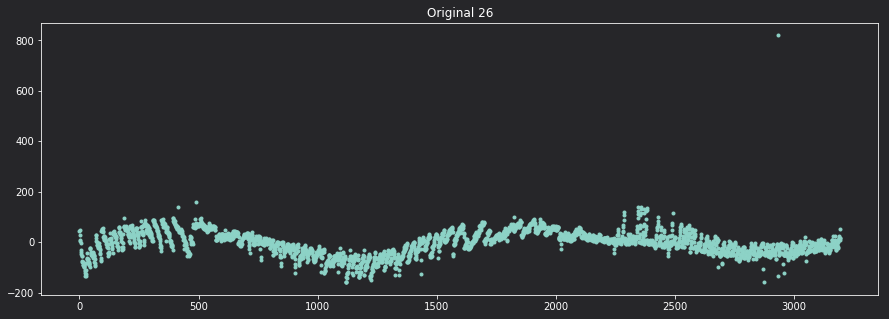

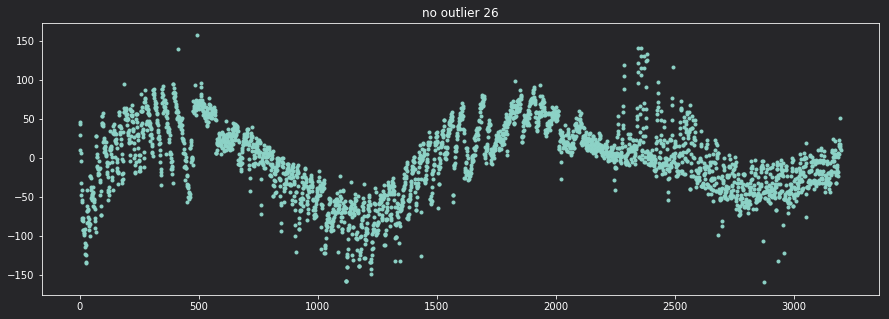

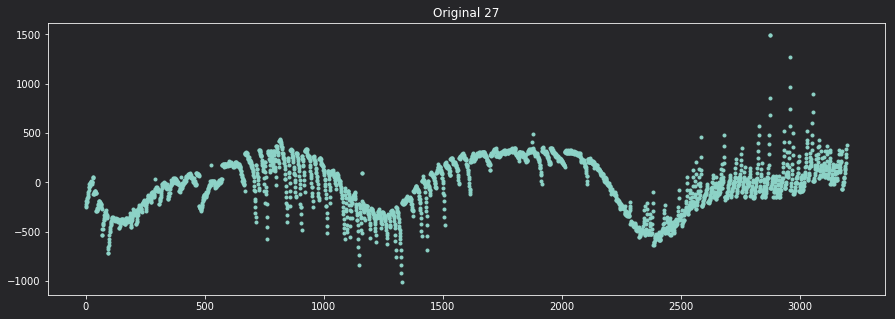

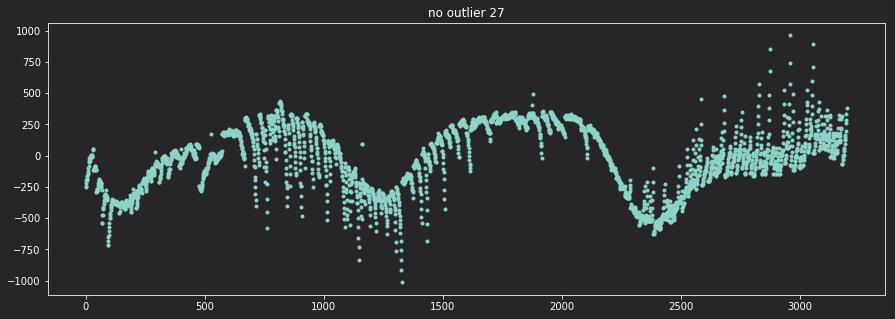

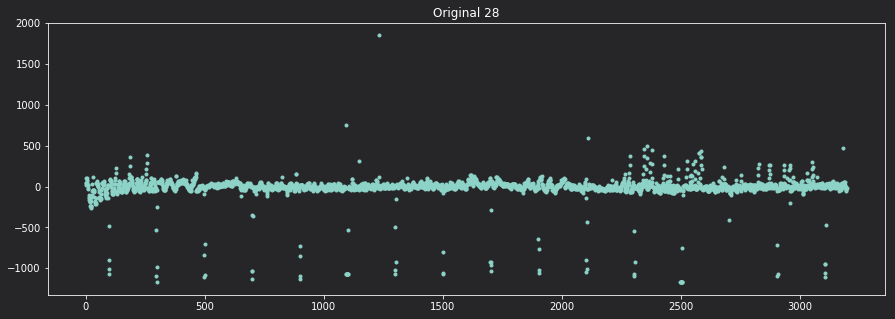

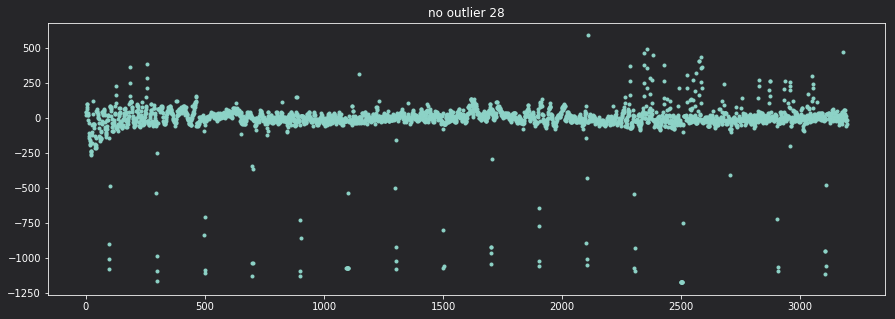

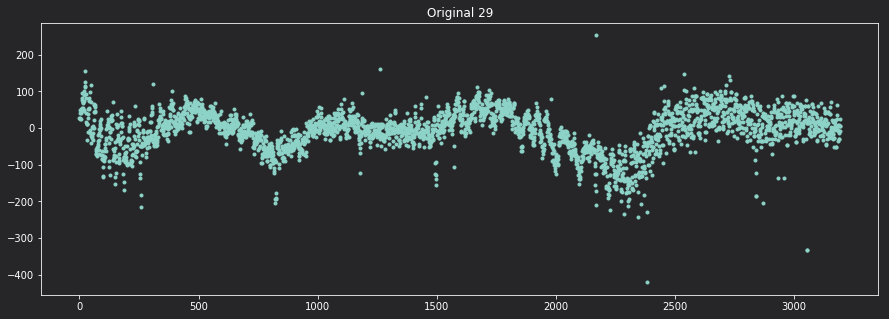

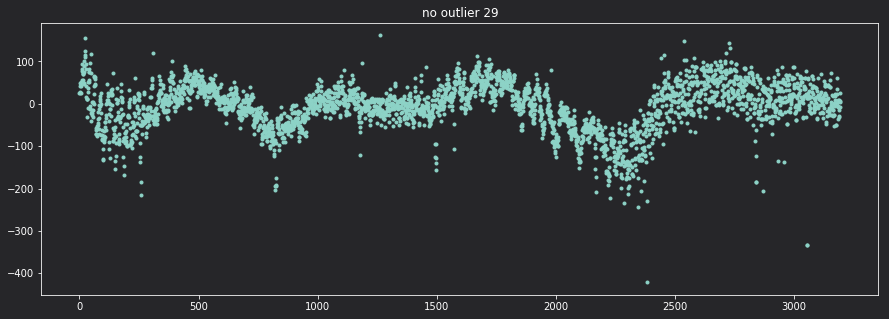

In [14]:

# for i in ids[:20]:
for i in range(30):
    plot(dataset[i], 'Original %d'%i)
    plot(remove_outlier(dataset[i]), 'no outlier %d'%i)

In [214]:
# Old algorithm
def outlier_removal(data):
    a = np.copy(data)
    median = np.median(a,axis=1)
    std = np.std(a,axis=1)
    x_new =[]
    x = np.copy(a)
    for i in xrange(x.shape[0]):
        index=[]
        r = pyasl.generalizedESD(x[i], 100, 2, fullOutput=True)
        r_1 = np.array(r[1])

        for j in xrange(x.shape[1]):
            if x[i][j] > median[i] + 2*std[i]:
                index.append(j)
        index = np.array(index)
    
        for k in np.intersect1d(index, r_1):
            x[i][k] = x[i][k-1]
        x_new.append(x[i])
    x_new = np.array(x_new)
    return x_new